In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras.backend as K
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import albumentations as albu
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from google.colab import files
uploaded = files.upload()
import zipfile
import io
zf = zipfile.ZipFile(io.BytesIO(uploaded['sjsu-cmpe-258-fa21-lab1-t.zip']), "r")
zf.extractall()
train_data = pd.read_csv('/content/train_data.csv',header=None)
test_data = pd.read_csv('/content/test_data.csv',header = None)
train_label = pd.read_csv('/content/train_label.csv')
train_array = train_data.to_numpy()
train_array_reshaped=np.reshape(train_array,(-1, 32, 32, 3))
test_array = test_data.to_numpy()
test_array_reshaped=np.reshape(test_array,(-1, 32, 32, 3))

Saving sjsu-cmpe-258-fa21-lab1-t.zip to sjsu-cmpe-258-fa21-lab1-t.zip


In [ ]:
y_list = []
for i in train_label['label']:
  y_list.append([i])
y_list = np.array(y_list)
#train_array_reshaped
#test_array_reshaped
#y_list

In [ ]:
# parameters for data
height = 32
width = 32
channels = 3
input_shape = (height, width, channels)
n_classes = 100

# parameters for optimizers
lr = 1e-3

# Parameters for training
epochs = 25
batch_size = 64

# parameters for callback functions
es_patience = 10
rlrop_patience = 5
decay_rate = 0.5

In [ ]:
fine_label_list =  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 
                    'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
                    'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 
                    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 
                    'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 
                    'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 
                    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 
                    'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 
                    'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

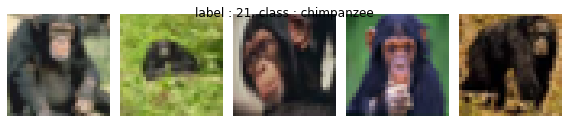

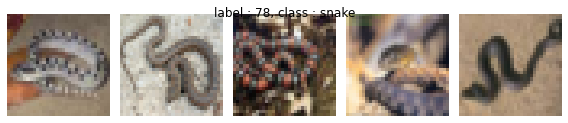

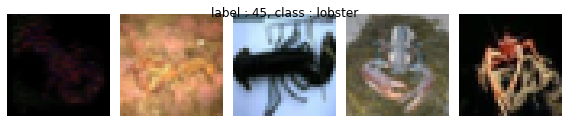

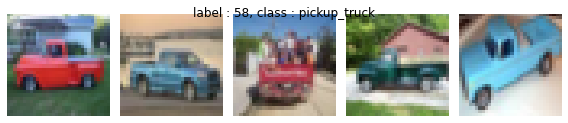

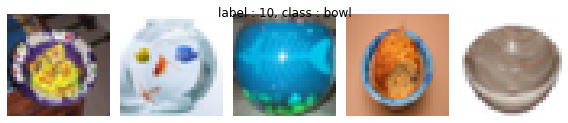

In [ ]:
class_plotted = np.random.choice(range(n_classes), 5, replace = False)
for i in range(len(class_plotted)):
    image_samples = train_array_reshaped[y_list.reshape(-1) == class_plotted[i]][:5]
    fig, ax = plt.subplots(nrows = 1, ncols = 5,figsize = (8,8))
    fig.suptitle("label : %d, class : %s" % (class_plotted[i], fine_label_list[class_plotted[i]]), y = .6)
    for j in range(5):
        ax[j].imshow(image_samples[j])
        ax[j].axis('off')  
    fig.tight_layout()
plt.show()

In [ ]:
st = StratifiedShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 1)
for train_index, val_index in st.split(train_array_reshaped, y_list):
    X_train, X_val, y_train, y_val = train_array_reshaped[train_index], train_array_reshaped[val_index], y_list[train_index], y_list[val_index]
    
print("The number of training data : ", X_train.shape[0])
print("The number of validation data : ", X_val.shape[0])

del train_array_reshaped, y_list

The number of training data :  8000
The number of validation data :  2000


In [ ]:
def np_resize(img, shape):
    return cv2.resize(img, (shape[1], shape[0]), interpolation = cv2.INTER_CUBIC)

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for keras'
    def __init__(self, images , labels = None, mode = 'fit', batch_size = batch_size,
                 dim = (height, width), channels = channels, n_classes = n_classes,
                 shuffle = True, augment = False):
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))
        
    def __getitem__(self, index):
        'Generate one batch of data'
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]


        X = np.empty((self.batch_size, *self.dim, self.channels))
        for i, ID in enumerate(batch_indexes):
            # Generate a preprocessed image
            img = self.images[ID]
            img = img.astype(np.float32) / 255.
            img = np_resize(img, self.dim)
            X[i] = img
            
        

        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            y = to_categorical(y, n_classes)
            '''
            y = np.zeros((self.batch_size, self.n_classes), dtype = np.uint8)
            for i, ID in enumerate(batch_indexes):
                # one hot encoded label
                y[i, self.labels[ID]] = 1
            '''
            
            if self.augment == True:
                X = self.__augment_batch(X)                
            
            return X,y
        
        elif self.mode == 'predict':
            return X       
        
        else:
            raise AttributeError('The mode parameters should be set to "fit" or "predict"')
            
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p = 0.5),
                                    albu.VerticalFlip(p = 0.5),
                                    albu.GridDistortion(p = 0.2),
                                    albu.ElasticTransform(p = 0.2)])
        
        return composition(image = img)['image']
        
    
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])
            
        return img_batch

In [ ]:
train_generator = DataGenerator(X_train, y_train, augment = True)
valid_generator = DataGenerator(X_val, y_val, augment = False)

In [ ]:
!pip install -U efficientnet

     |████████████████████████████████| 50 kB 3.1 MB/s 


In [ ]:
print(tf.__version__)

2.6.0


In [ ]:
pip install -U efficientnet==0.0.4

  Created wheel for efficientnet: filename=efficientnet-0.0.4-py3-none-any.whl size=14288 sha256=9100f92e17de8ae00be406c06a60c202d013c554ae66e722e358cf696315baca
  Stored in directory: /root/.cache/pip/wheels/e7/36/f8/f808aff9f50374552a83e73bb38e4e6b60285df3779a7d3279
Successfully built efficientnet
  Attempting uninstall: efficientnet
    Found existing installation: efficientnet 1.1.1
    Uninstalling efficientnet-1.1.1:
      Successfully uninstalled efficientnet-1.1.1


In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models
import efficientnet.tfkeras as efn



efnb0 = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape, classes=n_classes)

model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
# model.add(GlobalAveragePooling2D())
# model.add(Dropout(0.3))
model.add(Dense(n_classes, activation = 'softmax'))

model.summary()

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-im35ojwa
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-im35ojwa
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33810 sha256=c7d6ba46882ce36a91041fd0bf276f702ce650ddf47534a899cb59778fab7b39
  Stored in directory: /tmp/pip-ephem-wheel-cache-k3kitm57/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models
  Attempting uninstall: efficientnet
    Found existing installation: efficientnet 0.0.4
    Uninstalling efficientnet-0.0.4:
      Successfully uninstalled efficientnet-0.0.4
16818176/16804768 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-

In [ ]:
sgd = SGD(lr = lr, momentum = 0.9, nesterov = True)
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = es_patience, restore_best_weights = True, verbose = 1)
rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = rlrop_patience, 
                        factor = decay_rate, min_lr = 1e-6, verbose = 1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(), metrics = ['accuracy'])

In [ ]:
hist = model.fit_generator(train_generator,validation_data = valid_generator, 
                           epochs = epochs, verbose = 1, callbacks = [es, rlrop])

model.save_weights("best_weight.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
125/125 [==============================] - 54s 112ms/step - loss: 4.3637 - accuracy: 0.0774 - val_loss: 3.9717 - val_accuracy: 0.1069
Epoch 2/25
125/125 [==============================] - 12s 98ms/step - loss: 3.5062 - accuracy: 0.1813 - val_loss: 3.3908 - val_accuracy: 0.2273
Epoch 3/25
125/125 [==============================] - 12s 98ms/step - loss: 3.1449 - accuracy: 0.2454 - val_loss: 2.9088 - val_accuracy: 0.3044
Epoch 4/25
125/125 [==============================] - 12s 98ms/step - loss: 2.8645 - accuracy: 0.2956 - val_loss: 2.6436 - val_accuracy: 0.3493
Epoch 5/25
125/125 [==============================] - 13s 102ms/step - loss: 2.6839 - accuracy: 0.3288 - val_loss: 2.5911 - val_accuracy: 0.3634
Epoch 6/25
125/125 [==============================] - 12s 98ms/step - loss: 2.5342 - accuracy: 0.3623 - val_loss: 2.4672 - val_accuracy: 0.3871
Epoch 7/25
125/125 [==============================] - 12s 97ms/step - loss: 2.4355 - accuracy: 0.3862 - val_loss: 2.4942 - val_accurac

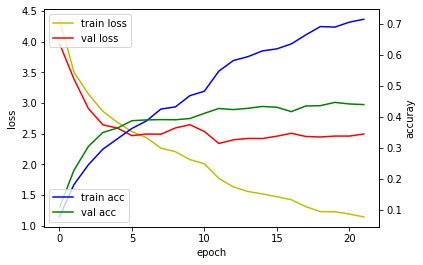

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()


In [ ]:
print("The Accuracy on the validation data : {:.2f}%".format(100 * model.evaluate_generator(valid_generator, verbose = 1)[-1]))

 3/31 [=>............................] - ETA: 1s - loss: 2.3800 - accuracy: 0.4115

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


31/31 [==============================] - 1s 32ms/step - loss: 2.3425 - accuracy: 0.4259
The Accuracy on the validation data : 42.59%


In [ ]:
test_generator = test_array_reshaped/255.0

In [ ]:
len(test_generator)

2000

In [ ]:
predictions = model.predict(test_generator)
print(predictions[1])
print(len(predictions))
predictions_list = []
for i in range(len(predictions)):
  predictions_list.append(np.argmax(predictions[i]))
# plt.figure(figsize = (15,2))
# plt.imshow((test_array_reshaped[0]*255).astype(int))
labels_id = []
for i in range(0,2000):
  labels_id.append(i)
labels_id_df = pd.DataFrame(labels_id,columns=['id'])
labels_id_df 

[2.60070988e-06 1.66402911e-04 8.81195135e-08 1.59608953e-06
 3.55472730e-04 3.84495661e-06 3.02593548e-06 5.13756713e-05
 4.50868429e-05 2.12905026e-04 1.00038842e-05 1.10948008e-07
 4.06464005e-06 6.33479829e-07 2.95208320e-05 9.80535970e-06
 5.63607409e-06 1.01815886e-07 3.23022658e-04 3.84535633e-06
 3.13432025e-07 2.45888732e-05 6.51537906e-04 2.06387900e-02
 1.42197625e-03 1.91975942e-05 1.96832023e-03 5.73013067e-01
 2.97112711e-04 1.56615988e-05 4.13015150e-05 2.04917538e-04
 3.82722472e-04 5.27159916e-03 1.04946439e-05 2.66540070e-07
 4.25654520e-07 7.66012988e-07 3.79879551e-04 4.46102740e-06
 2.24885594e-06 7.70628503e-07 1.02409003e-02 6.41503313e-04
 2.83131413e-02 3.66918184e-02 1.78145237e-05 6.16333215e-04
 4.91283845e-06 9.89794426e-05 1.27293426e-03 1.11413165e-05
 4.44712678e-05 3.11195390e-06 8.61579792e-06 1.15241786e-03
 4.46551348e-06 3.40708607e-06 5.98682636e-05 2.77978452e-05
 3.62005994e-05 4.48721767e-06 3.09887241e-06 1.36113204e-02
 6.82513128e-05 2.762340

,id
0,0
1,1
2,2
3,3
4,4
...,...
1995,1995
1996,1996
1997,1997
1998,1998


In [ ]:
y_pred_df = pd.DataFrame(predictions_list) 
final_labels_df = [labels_id_df['id'],y_pred_df[0]]
headers = ['id','label']
final_prediction_df = pd.concat(final_labels_df, axis=1, keys=headers)
final_prediction_df

,id,label
0,0,50
1,1,27
2,2,41
3,3,17
4,4,14
...,...,...
1995,1995,14
1996,1996,8
1997,1997,39
1998,1998,95


In [ ]:
final_prediction_df.to_csv('predictions_3_part2.csv',index=False)